# Automatic Detection of ICME shocks in WIND data

The following notebook was designed to show the importance of deriving ICME signatures from the first couple hours. The code borrows heavily from [Automatic Detection of ICMEs at 1 AU: A deep learning approach](https://github.com/gautiernguyen/Automatic-detection-of-ICMEs-at-1-AU-a-deep-learning-approach), which is based on [Automatic detection of Interplanetary Mass Ejections from in-situ data: a deep learning approach](https://arxiv.org/pdf/1903.10780.pdf). However, this code was adapted in order to focus on detecting the first 7 hours of an ICME and thereby functions as sort of an "early warning system". We only include events where a shock is present into our catalogue in order to facilitate learning for the deep learning algorithm. <br> <br>

### Results

The results of the pipeline are promising: <br>
<br>
True positive Rate is: 0.428<br>
Precision is: 0.5<br>
Recall is: 0.818<br>
True Positives 9<br>
False Negatives 2<br>
False Positives 9<br>

Even though not all predicted similarities are in fact categorized as an ICME start by the postprocessing, visually examining the events shows a clear rise in the similarity parameter for all events in the testset. The number of false positives is reasonable considering the possibility of additional events, which are not part of the current catalogue. 

#### Software Dependencies

- pickle 4.0
- numpy 1.19.5
- matplotlib 3.1.2
- pandas 1.1.5
- h5py 3.1.0
- joblib 1.0.1
- lmfit 1.0.2
- opencv-python 4.5.2.54
- pyarrow 4.0.1
- scikit-image 0.17.2
- scikit-learn 0.24.2
- scipy 1.5.4
- seaborn 0.11.1
- tensorflow 2.5.0

In [25]:
# limit the usage of CUDA server 
import os
#os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
#os.environ["CUDA_VISIBLE_DEVICES"]="7"  #Device ID

In [2]:
%load_ext autoreload
%autoreload 2

#import packages

import pickle
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.dates import date2num, num2date
import pandas as pds
import datetime
import pytz
from sklearn.preprocessing import StandardScaler


from tensorflow import keras

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Conv1D, MaxPooling1D, Flatten
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau


import event as evt
import features
import windows as wdw
import preProcess
from scipy.ndimage import median_filter

The history saving thread hit an unexpected error (DatabaseError('database disk image is malformed')).History will not be written to the database.


In [3]:
# load ICME catalog data

[ic,header,parameters] = pickle.load(open('data/HELCATS_ICMECAT_v20_pandas.p', "rb" ))

# extract important values

isc = ic.loc[:,'sc_insitu'] 
starttime = ic.loc[:,'icme_start_time']
mo_start_time = ic.loc[:,'mo_start_time']

# Event indices from Wind
iwinind = np.where(isc == 'Wind')[0]

# Event indices where the start time of the CME does not match the start time of the magnetic obstacle
n_iwinind = np.where(starttime[iwinind] != mo_start_time[iwinind])[0]

i_icme_start_time= np.arange(len(starttime))
n_iwinind = i_icme_start_time[iwinind][n_iwinind]

feature_hours = 7

winbegin = starttime[n_iwinind]
winend = winbegin + datetime.timedelta(hours=feature_hours)

# get list of events

evtList = evt.read_cat(winbegin, winend, n_iwinind)

# Load Wind data
[win, winheader] = pickle.load(open("data/wind_2007_2021_heeq_ndarray.p", "rb"))



In [4]:
# pre process on the data set

data = pds.DataFrame(win)
data['time'] = matplotlib.dates.num2date(data['time'], tz=None) 
data['time'] = pds.to_datetime(data['time'], format="%Y/%m/%d %H:%M")
data.set_index('time',  inplace=True)
data.index.name = None
data.index = data.index.tz_localize(None)
data.drop(['x', 'y', 'z', 'r', 'lat', 'lon'], axis = 1,  inplace=True)

# compute additional features

features.computeBetawiki(data)
features.computePdyn(data)
features.computeRollingStd(data, 3, 'bt', center=False)
features.computeTexrat(data)

# resample data
data = data.resample('10T').mean().dropna()

In [5]:
# setting window sizes
windows = np.arange(1,feature_hours+1,1)

In [6]:
import joblib
from joblib import Parallel, delayed

# computation of the similarity parameter, takes rather long
results = Parallel(n_jobs=20)(delayed(evt.get_similarity)(data.index, width, evtList) for width in windows)

similarities = pds.DataFrame(index = data.index)
for width in windows:
    similarities[width] = results[width-1]
similarities.to_csv('similarities.csv')

In [7]:
# load similarity values from file

similarities = pds.read_csv('similarities.csv', index_col = 0)

In [8]:
# set training, validation and testset

X_train = data[(data.index<datetime.datetime(2019,1,1)) & (data.index>datetime.datetime(2008,1,1))]
X_val = data[data.index<datetime.datetime(2008,1,1)]
X_test = data[data.index>datetime.datetime(2019,1,1)]

In [9]:
# perform scaling

scale = StandardScaler()
scale.fit(X_train)
X_train = scale.transform(X_train)
X_val = scale.transform(X_val)
X_test = scale.transform(X_test)

In [10]:
# callbacks
callbacks = []

# reduce learning-rate when reaching plateau
callbacks.append(
    ReduceLROnPlateau(monitor='val_loss', factor=0.5,
                      patience=5, min_delta=0.001,
                      cooldown=1, verbose=1))

# add early stopping
callbacks.append(
    EarlyStopping(monitor='val_loss', min_delta=0.001,
                  patience=10, verbose=1))

In [11]:
# create model, fit and predict

def fit_and_predict(X_train,X_val, X_test, width, y, data):
    
    window = int(60 * width)
    X_train_windowed = wdw.windowed(X_train, window=window)
    X_test_windowed = wdw.windowed(X_test, window=window)
    X_val_windowed = wdw.windowed(X_val, window=window)

    y_train = y[(data.index < datetime.datetime(2019, 1, 1))
                & (data.index > datetime.datetime(2008, 1, 1))][int(window/2)-1:-int(window/2)]

    y_val = y[data.index < datetime.datetime(2008, 1, 1)][int(window/2)-1:-int(window/2)]
    y_test = y[data.index > datetime.datetime(2019, 1, 1)][int(window/2)-1:-int(window/2)]

    weights = preProcess.get_weights(y, 10)

    weight_train = weights[(data.index < datetime.datetime(2019, 1, 1))
                & (data.index > datetime.datetime(2008, 1, 1))][int(window/2)-1:-int(window/2)]

    
    input_shape = (window, data.shape[1])

    model = Sequential()
    model.add(
        Conv1D(
            20,
            kernel_size=3,
            padding='causal',
            activation='relu',
            input_shape=input_shape))
    model.add(
        Conv1D(
            20,
            kernel_size=3,
            padding='causal',
            activation='relu',
            input_shape=input_shape))
    model.add(
        Conv1D(
            20,
            kernel_size=3,
            padding='causal',
            activation='relu',
            input_shape=input_shape))
    model.add(
        Conv1D(
            20,
            kernel_size=3,
            padding='causal',
            activation='relu',
            input_shape=input_shape))
    model.add(MaxPooling1D())
    model.add(
        Conv1D(
            20,
            kernel_size=3,
            padding='causal',
            activation='relu',
            input_shape=input_shape))
    model.add(
        Conv1D(
            20,
            kernel_size=3,
            padding='causal',
            activation='relu',
            input_shape=input_shape))
    model.add(
        Conv1D(
            20,
            kernel_size=3,
            padding='causal',
            activation='relu',
            input_shape=input_shape))
    model.add(
        Conv1D(
            20,
            kernel_size=3,
            padding='causal',
            activation='relu',
            input_shape=input_shape))
    model.add(MaxPooling1D())
    model.add(Flatten())
    model.add(Dropout(0.2))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='logcosh', optimizer='sgd')

    model.fit(
        X_train_windowed,
        y_train,
        epochs=100,
        batch_size=128,
        verbose=1,
        validation_data=(X_val_windowed, y_val),
        callbacks=callbacks,
        sample_weight=weight_train
        )
    model.save('model'+str(width))
    
    y_pred = model.predict(X_test_windowed, verbose=1)
    y_predSeries = pds.Series(
        index=data[data.index>datetime.datetime(2019,1,1)].index[int(window/2)-1:-int(window/2)],
        data=np.array([y_pred[i][0] for i in range(0, len(y_pred))]))

    return y_predSeries

In [12]:
# Fit and prediction of the model

for width in windows:
    prediction = fit_and_predict(X_train, X_val, X_test, width, similarities[str(width)], data)
    prediction.to_csv('pred'+str(width)+'.csv')
    

Epoch 1/100
4402/4402 [==============================] - 43s 10ms/step - loss: 0.0150 - val_loss: 4.8824e-05
Epoch 2/100
4402/4402 [==============================] - 42s 10ms/step - loss: 3.6620e-04 - val_loss: 3.2954e-05
Epoch 3/100
4402/4402 [==============================] - 42s 10ms/step - loss: 3.5129e-04 - val_loss: 2.8872e-05
Epoch 4/100
4402/4402 [==============================] - 43s 10ms/step - loss: 3.6991e-04 - val_loss: 2.7085e-05
Epoch 5/100
4402/4402 [==============================] - 40s 9ms/step - loss: 3.5374e-04 - val_loss: 2.6082e-05
Epoch 6/100
4402/4402 [==============================] - 42s 10ms/step - loss: 3.5528e-04 - val_loss: 2.5481e-05

Epoch 00006: ReduceLROnPlateau reducing learning rate to 0.004999999888241291.
Epoch 7/100
4402/4402 [==============================] - 39s 9ms/step - loss: 3.4764e-04 - val_loss: 2.5255e-05
Epoch 8/100
4402/4402 [==============================] - 43s 10ms/step - loss: 3.3502e-04 - val_loss: 2.5064e-05
Epoch 9/100
4402/4402 

In [19]:
# prediction loading

prediction = pds.DataFrame(index = data[data.index>datetime.datetime(2019,1,1)].index)

for width in windows :
    coll = np.zeros(len(prediction))
    df = pds.read_csv('pred'+str(width)+'.csv', header=None, index_col=None)
    df.drop([0], inplace = True)
    df.set_index([0], inplace = True)
    dfv = df.values.reshape([len(df.values)])
    coll[prediction.index.isin(df.index)] = dfv
    prediction[str(width)] = coll
    
prediction = pds.DataFrame(index = prediction.index, data = median_filter(prediction.values, (1,5)))


In [20]:
#From raw prediction to ICME list

import postProcess

integral = prediction.sum(axis=1)
ICMEs, pred = postProcess.turn_peaks_to_clouds(integral, 0.8)
test_clouds = [x for x in evtList if x.begin>datetime.datetime(2019,1,1)]

In [21]:
#Score by event

import performance as prf

TP, FN, FP, detected = prf.evaluate(ICMEs, test_clouds, thres=0.1)
print('True positive Rate is:',len(TP)/len(ICMEs))
print('Precision is:',len(TP)/(len(TP)+len(FP)))
print('Recall is:',len(TP)/(len(TP)+len(FN)))
print('True Positives', len(TP))
print('False Negatives', len(FN))
print('False Positives', len(FP))

True positive Rate is: 0.36363636363636365
Precision is: 0.6666666666666666
Recall is: 0.7272727272727273
True Positives 8
False Negatives 3
False Positives 4


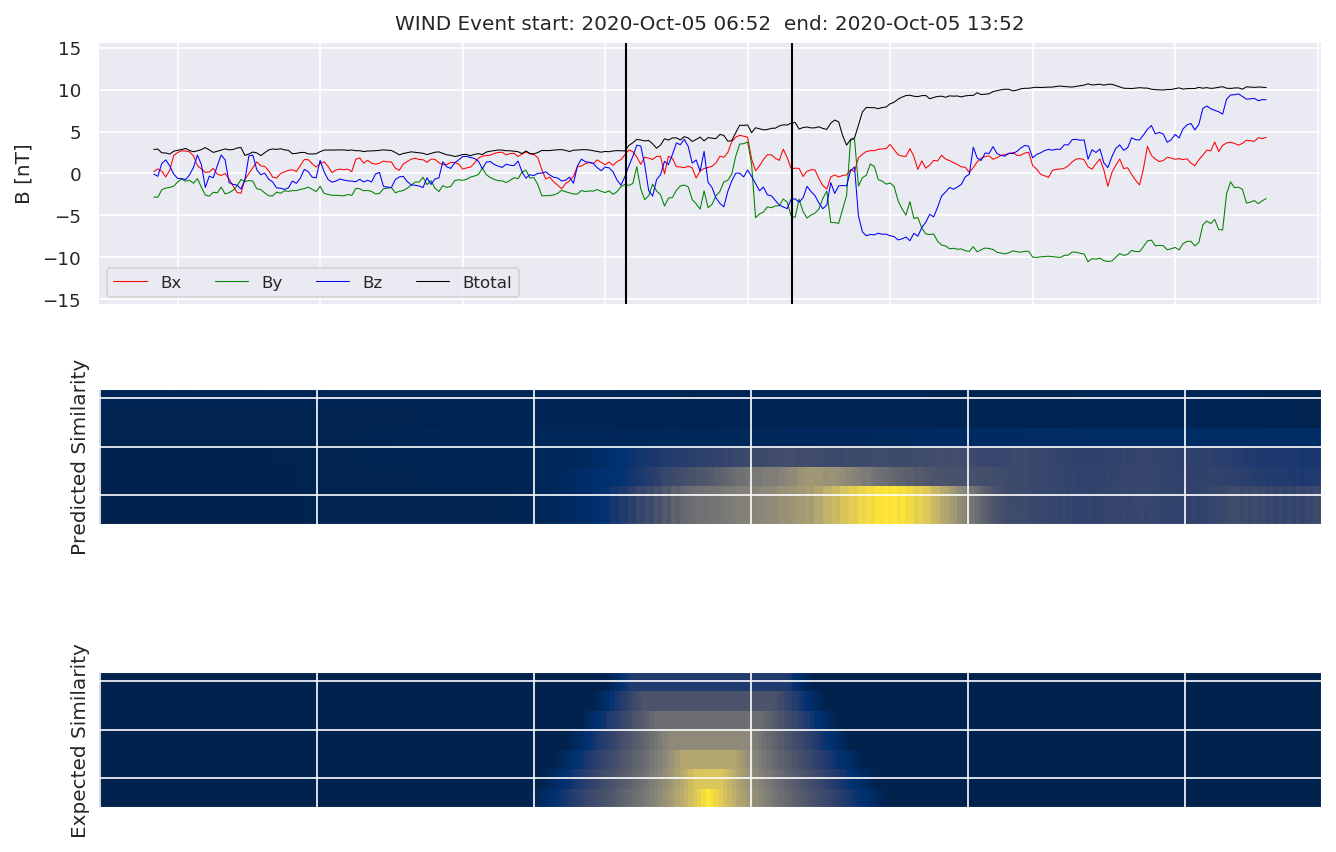

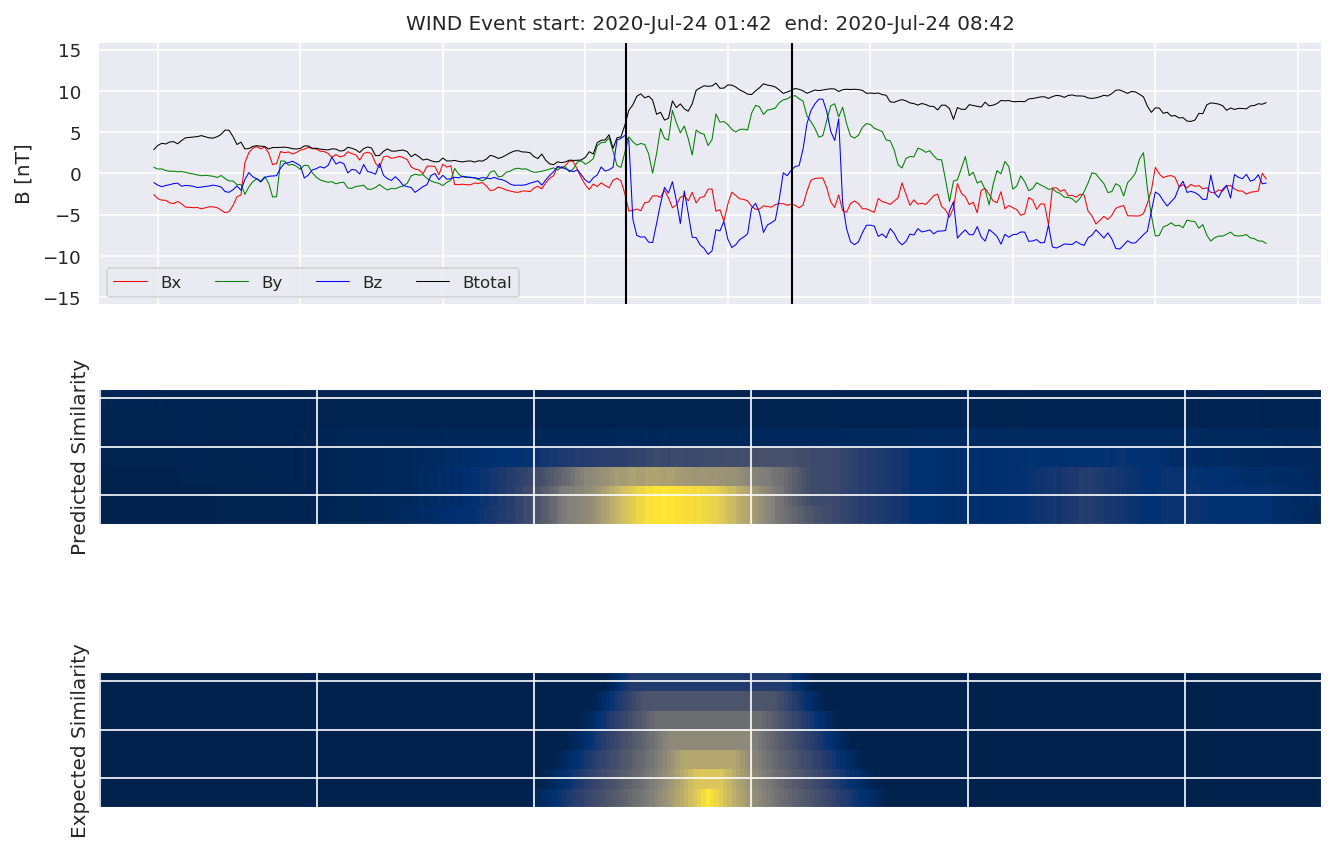

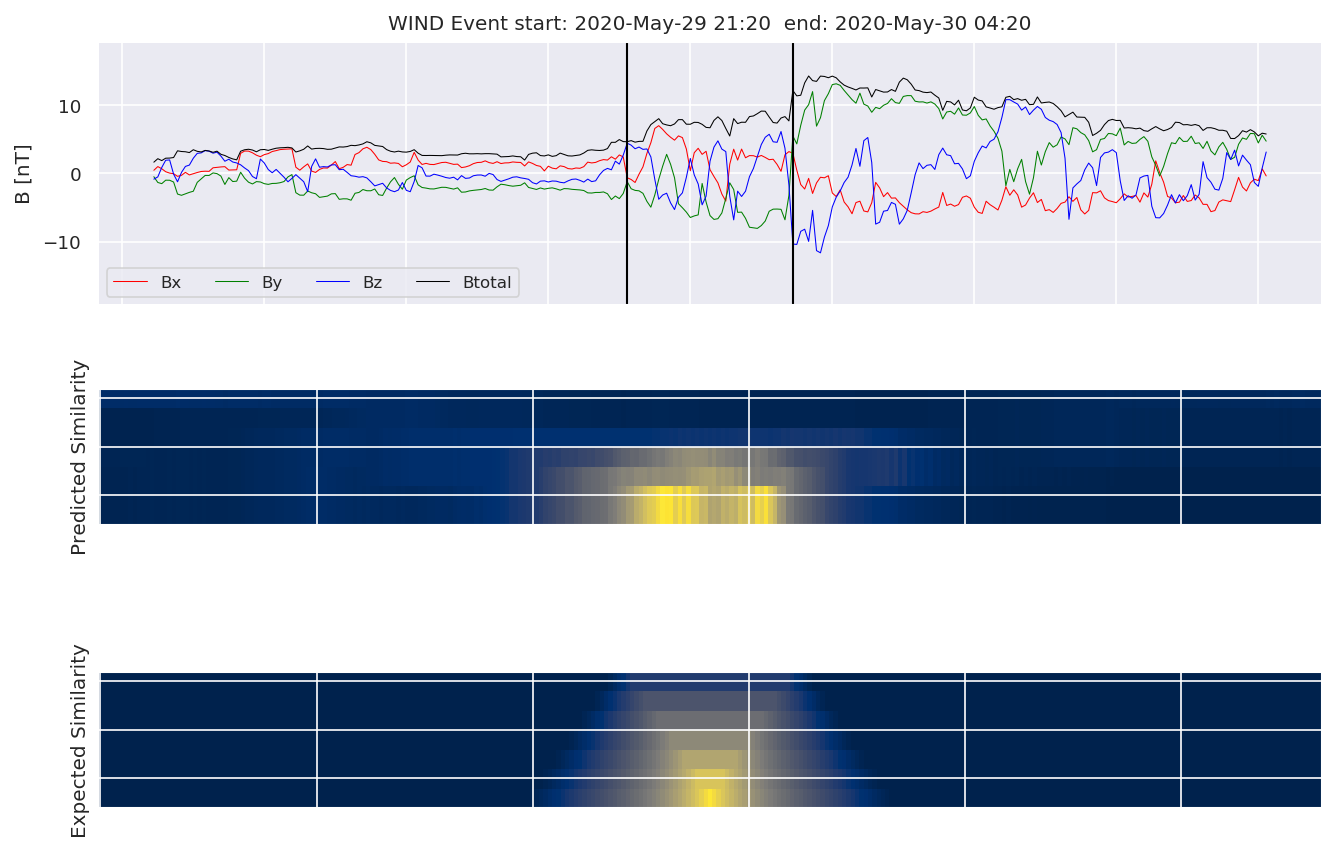

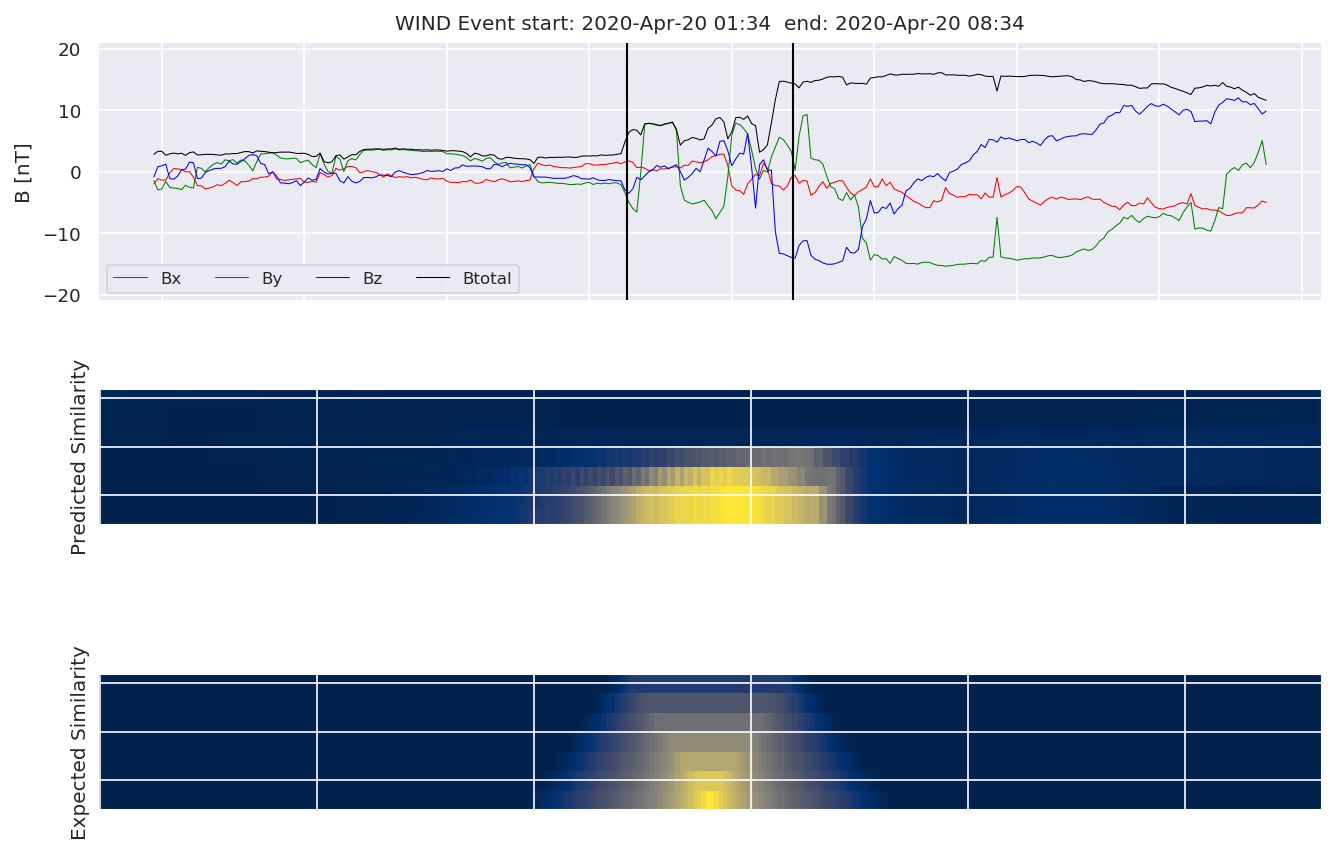

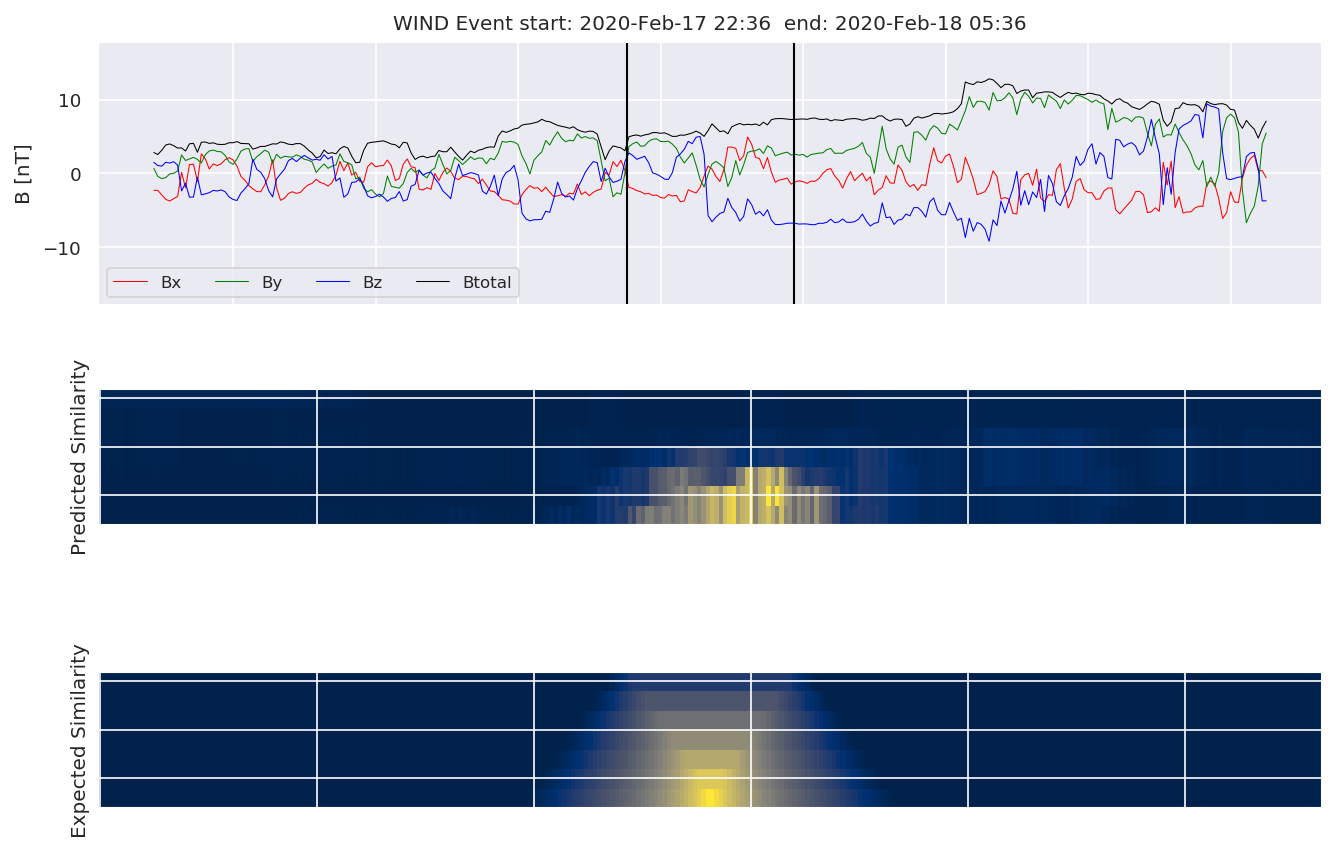

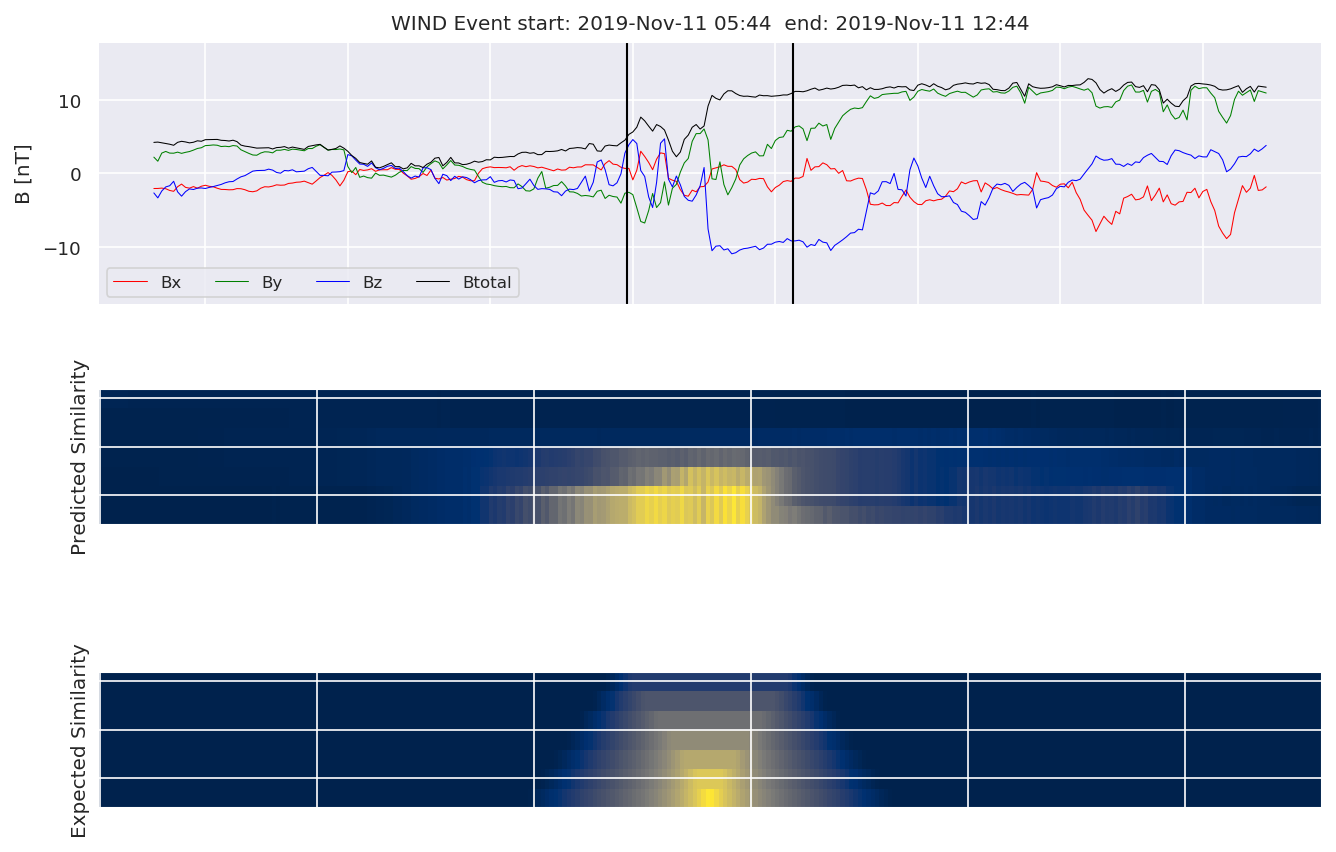

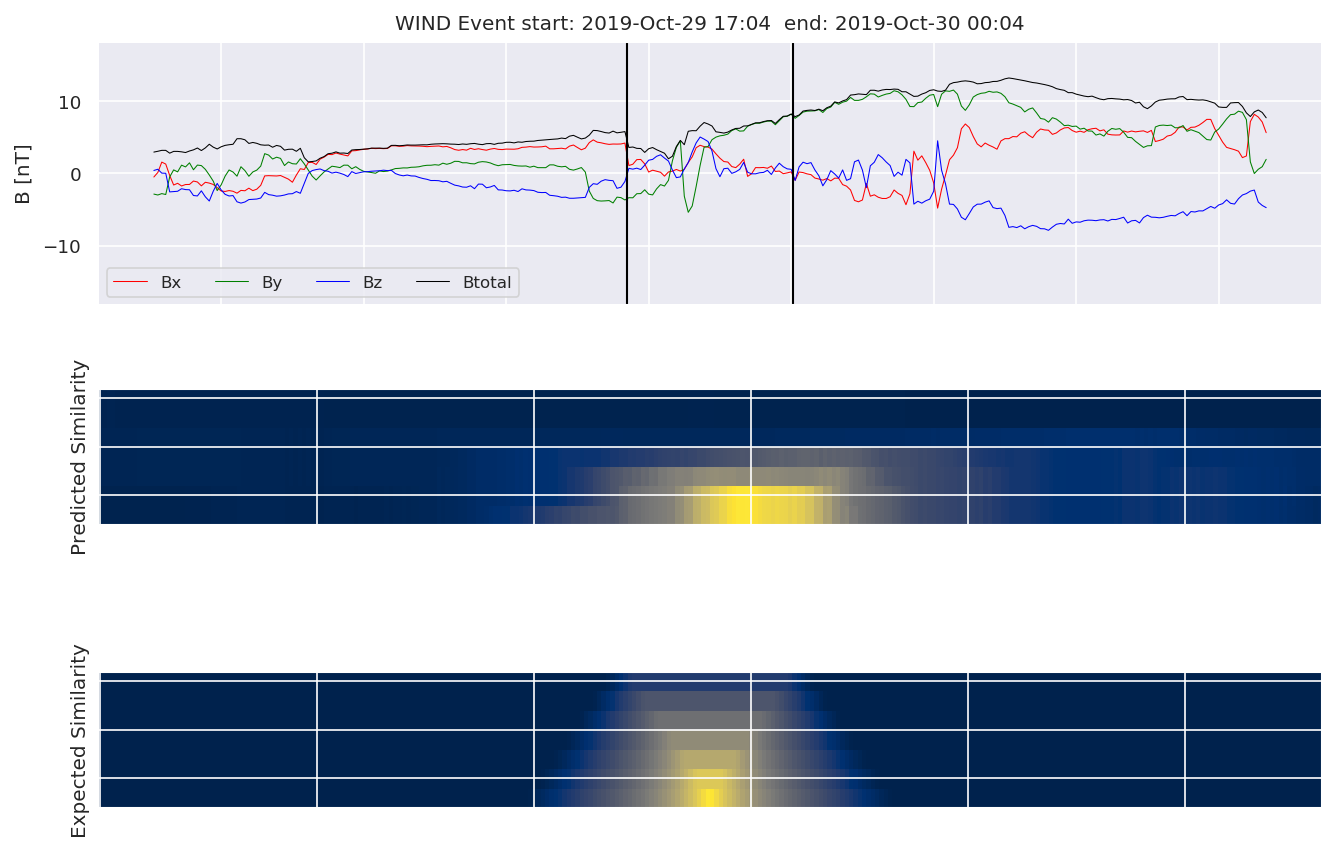

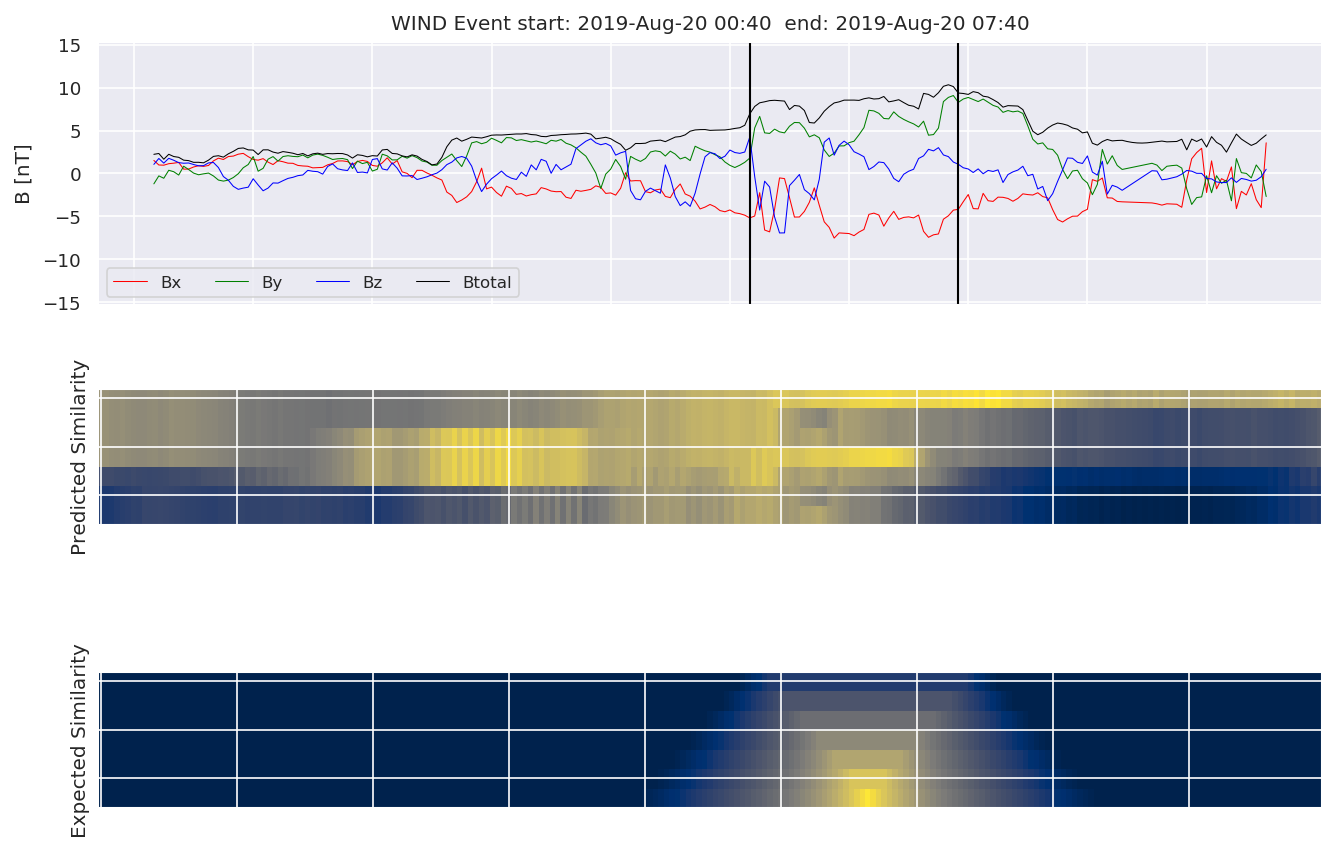

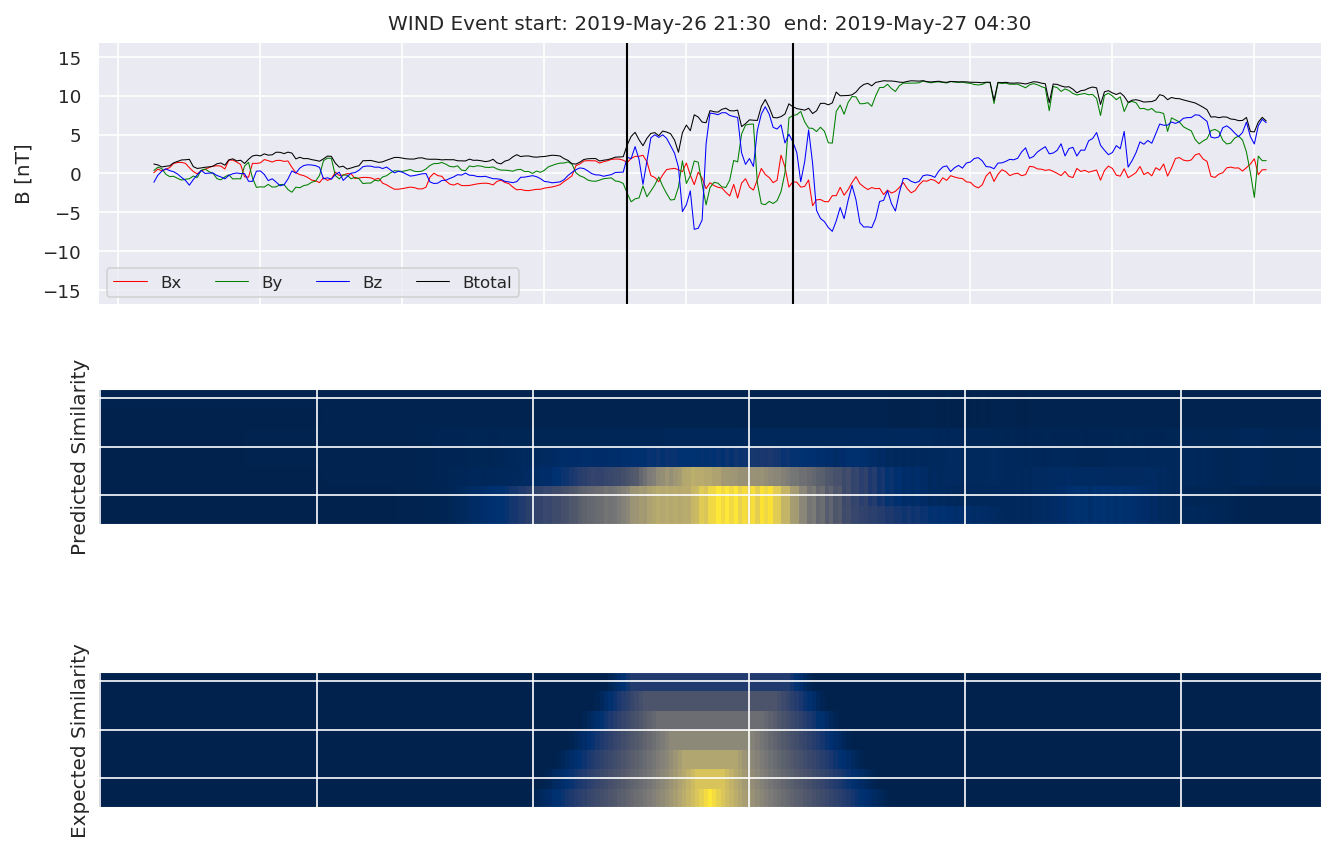

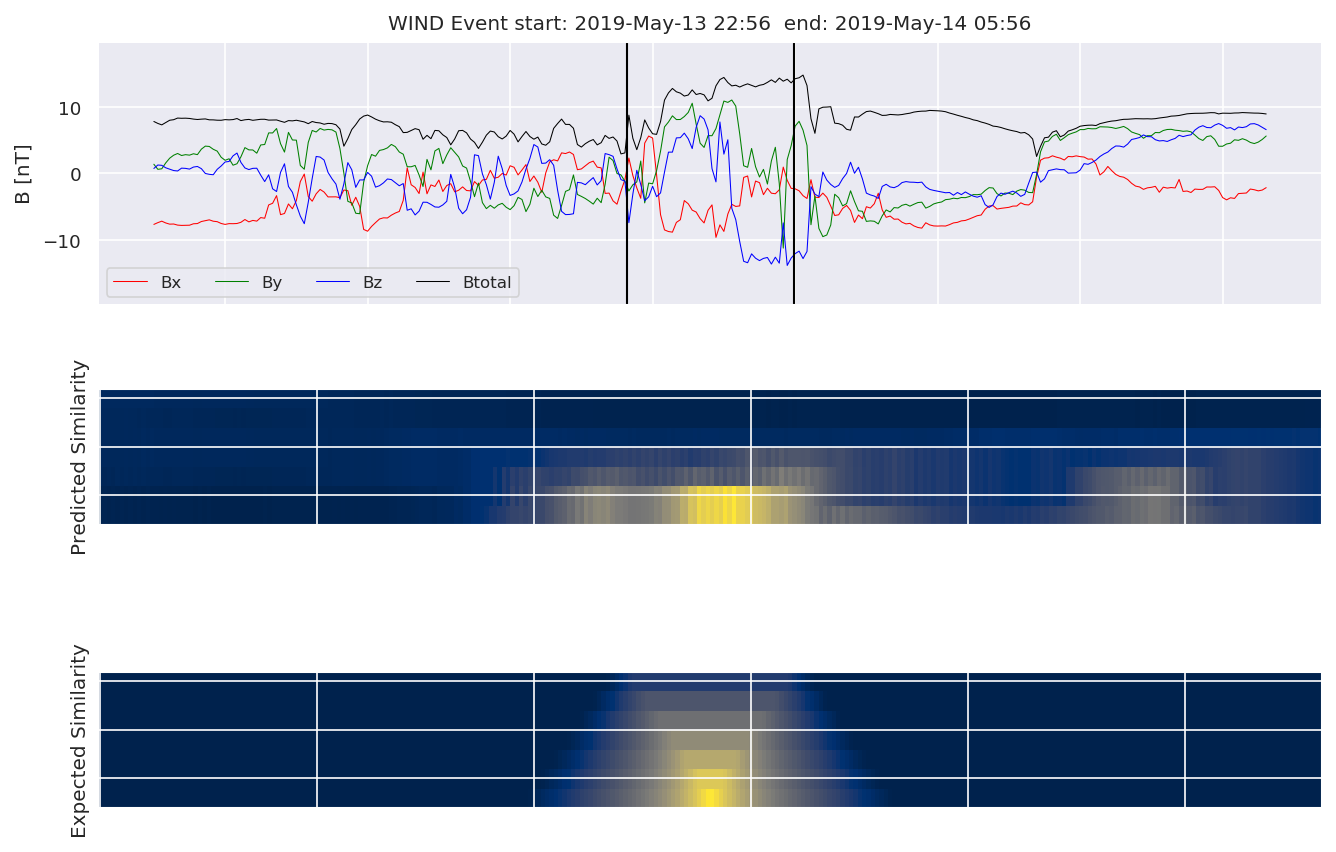

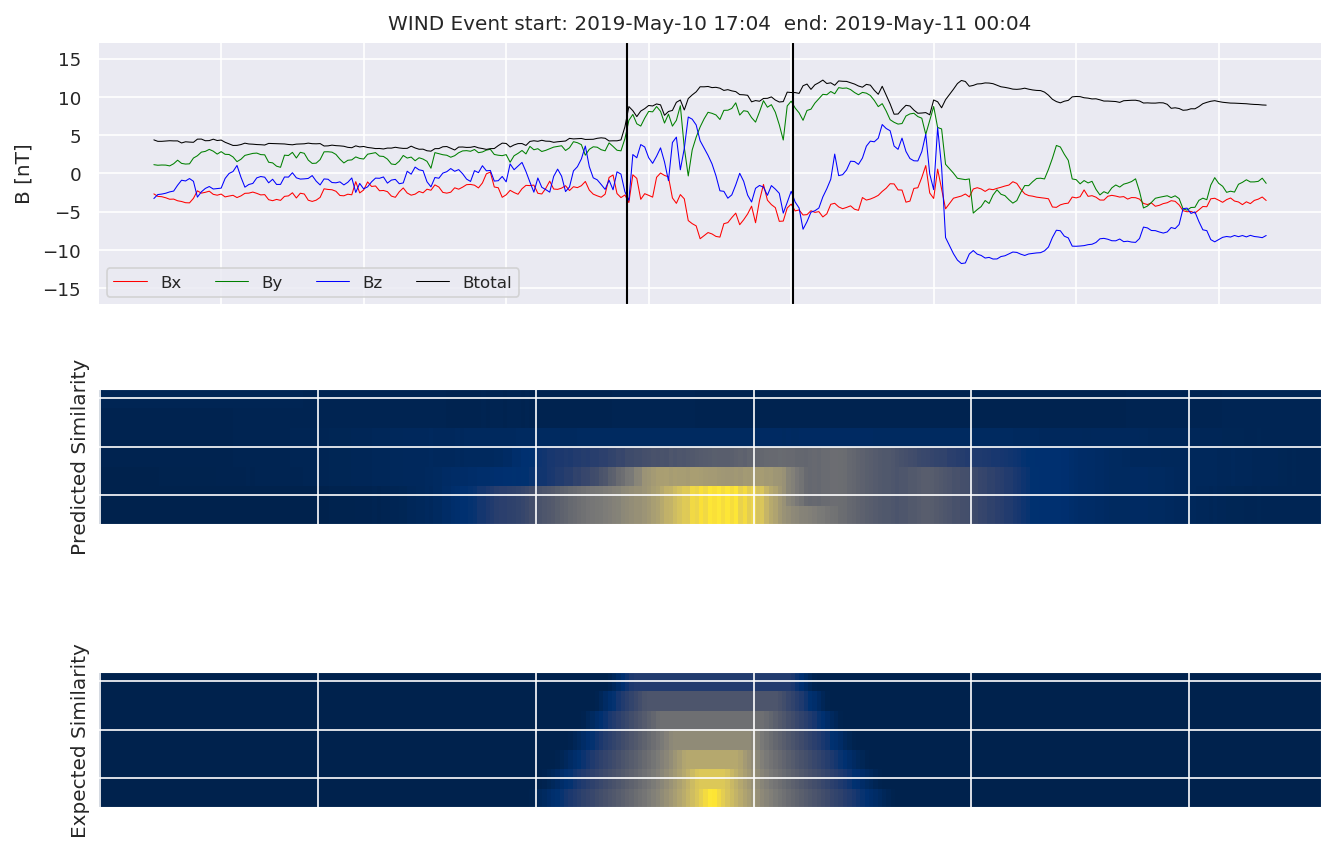

In [23]:
#Plot events and associated similarity values
# Don't print warnings
import warnings
warnings.filterwarnings('ignore')

for i in range(0, len(test_clouds)):
    test_clouds[i].heatplot(data,20,i,'WIND Event',prediction, similarities)

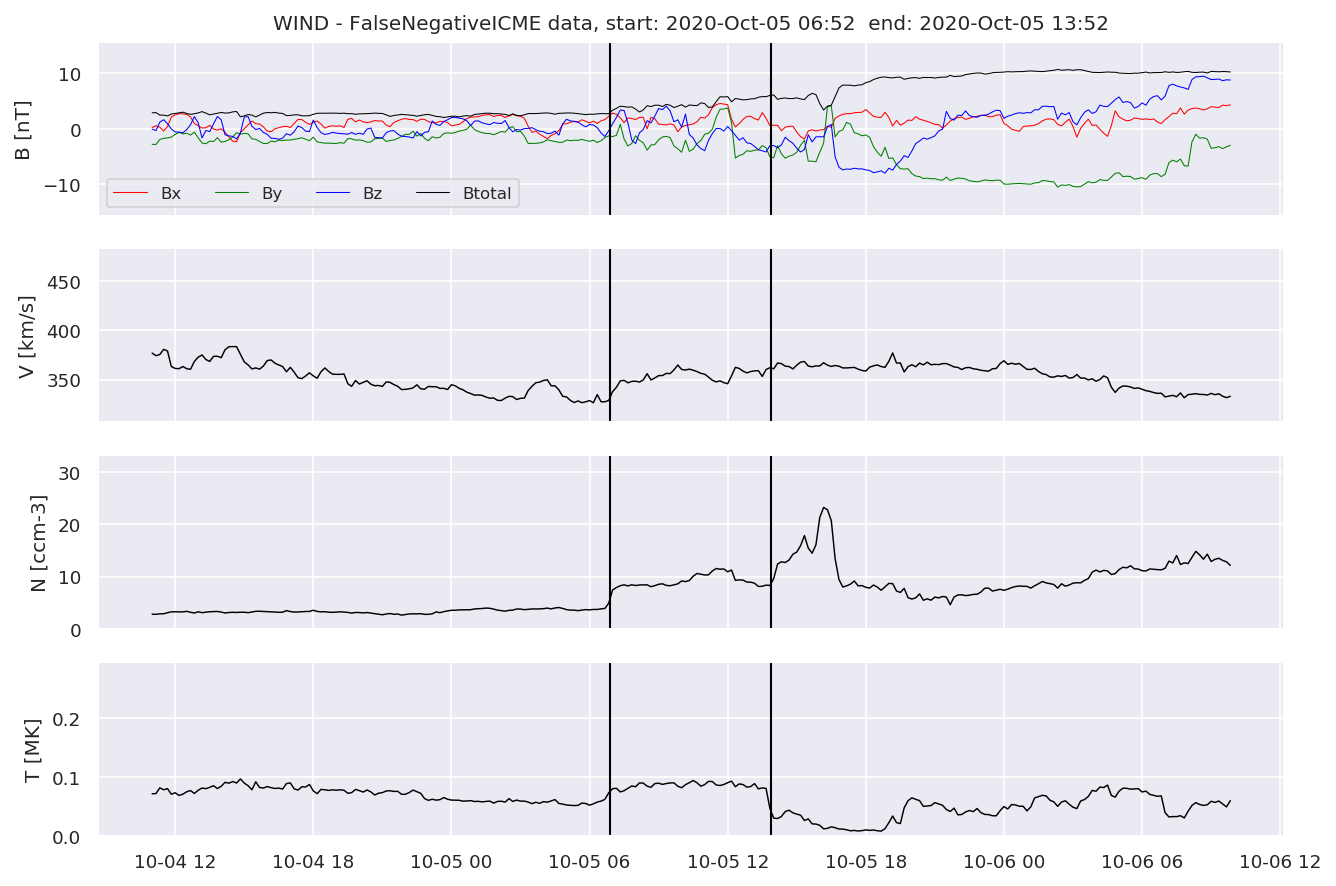

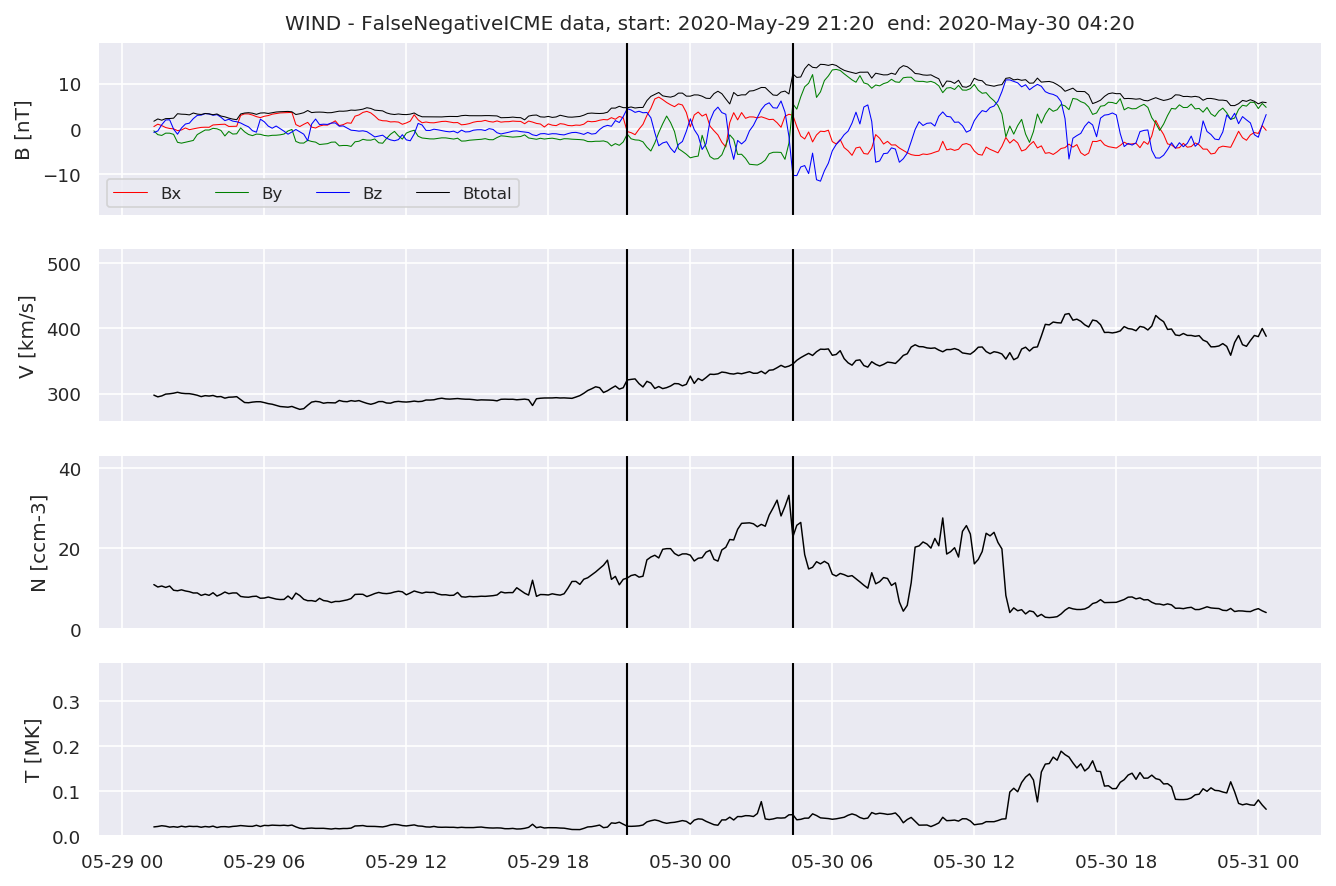

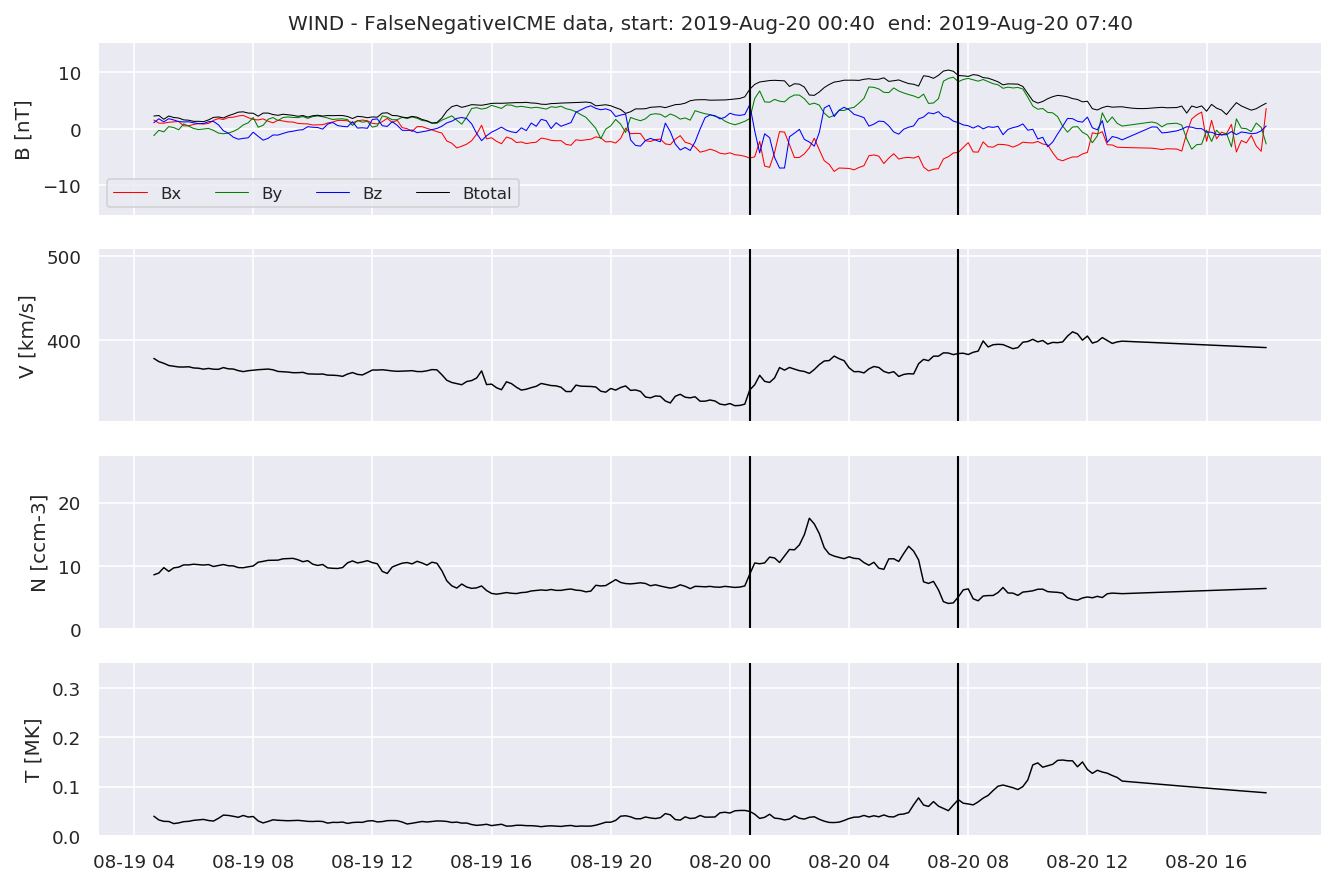

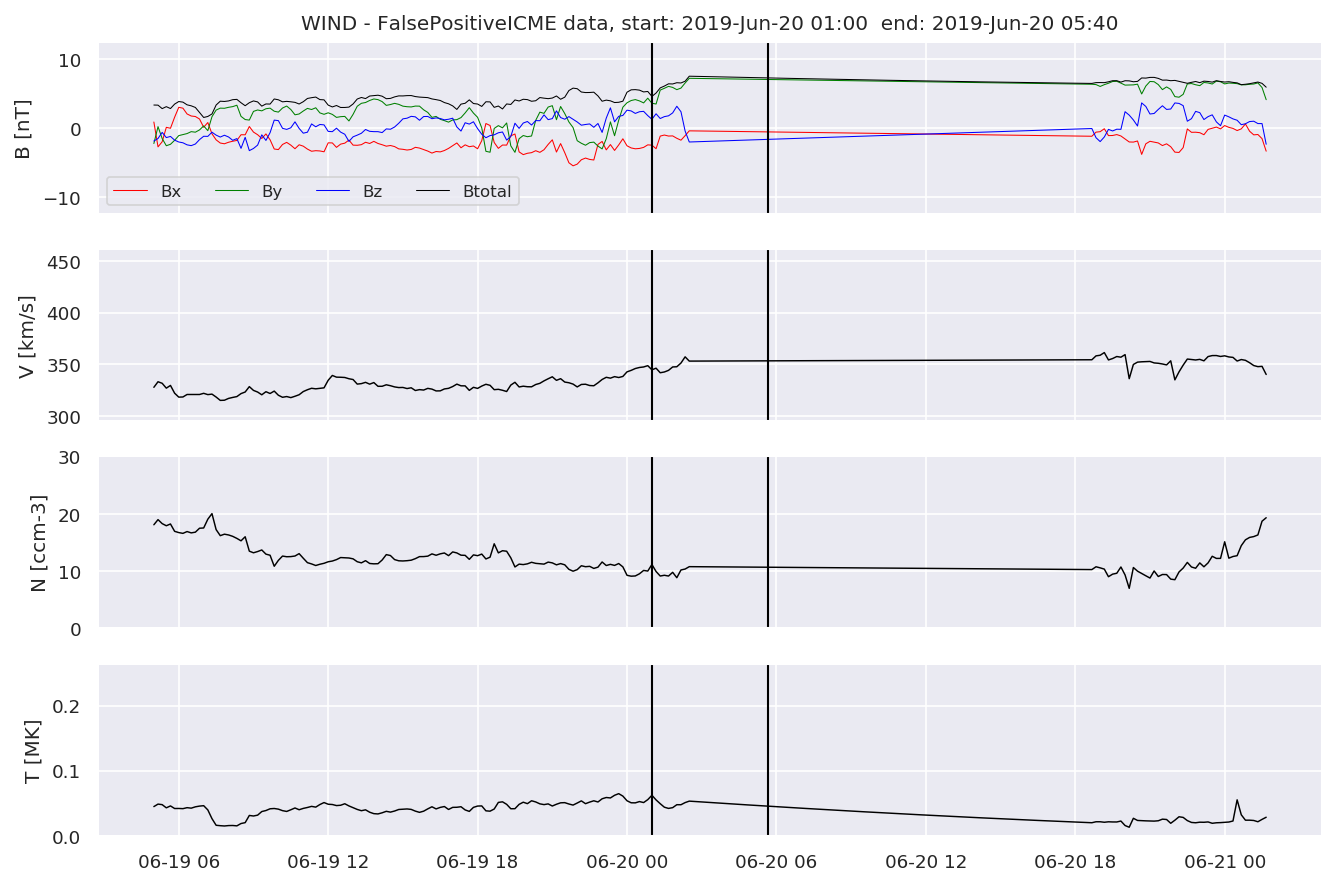

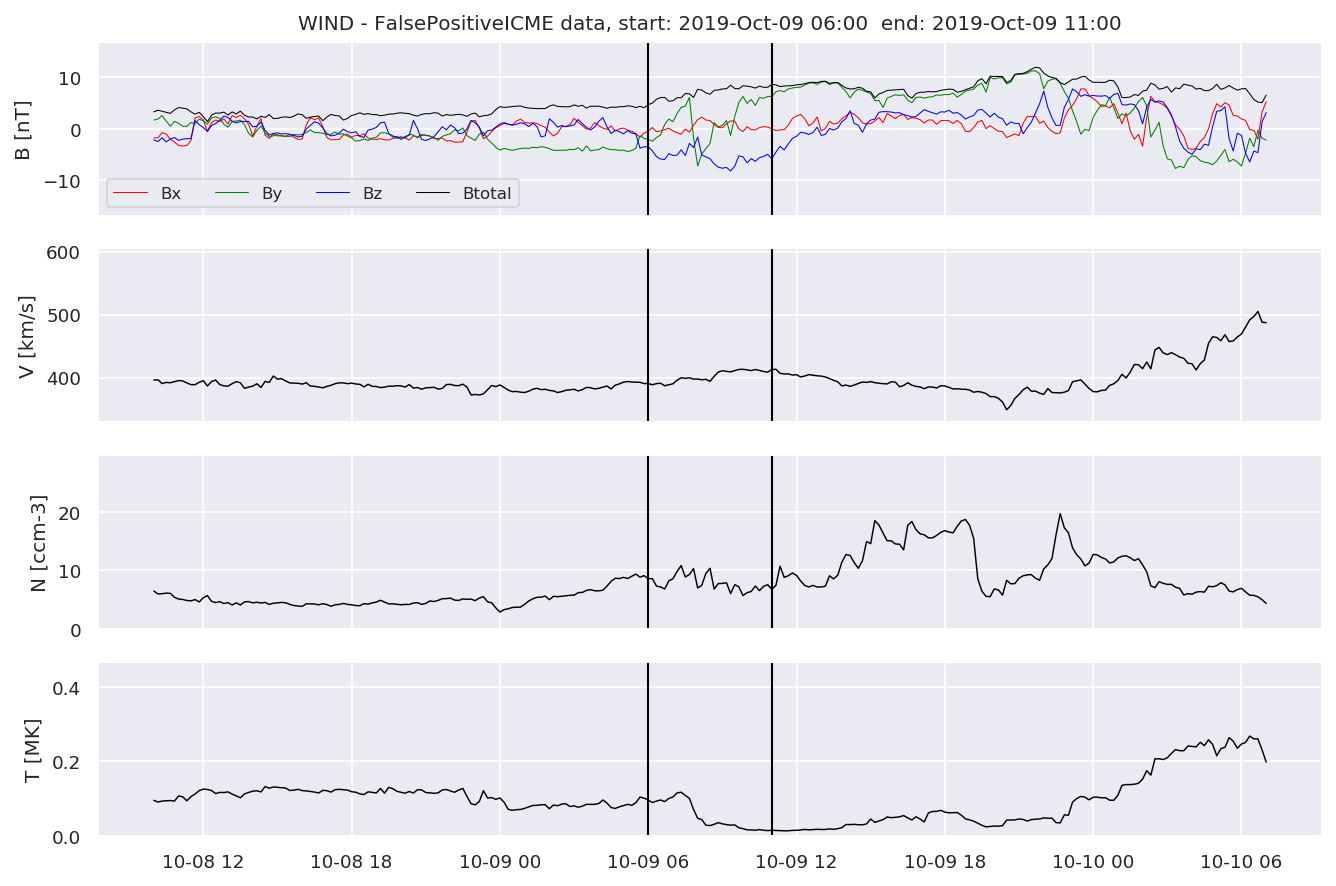

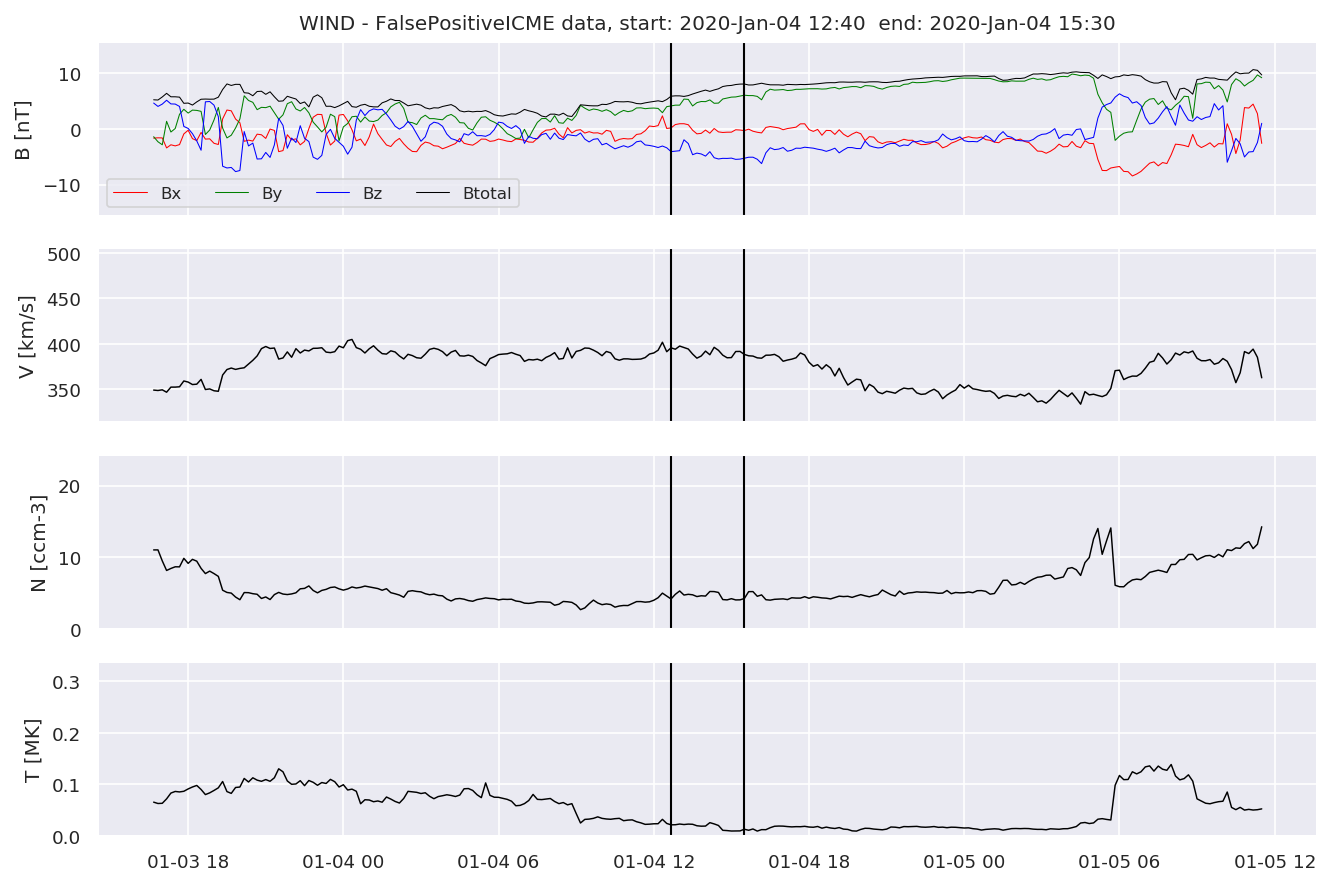

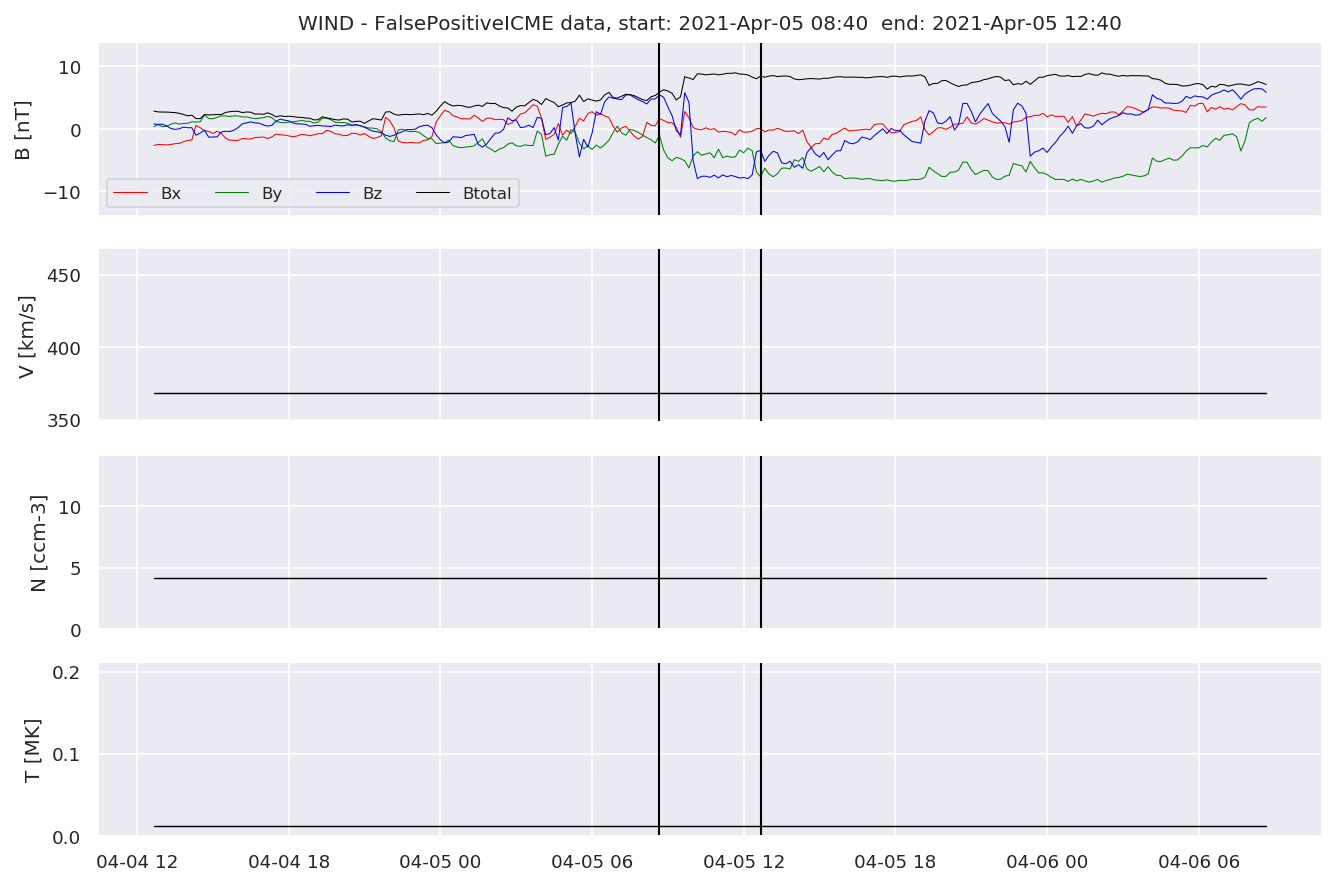

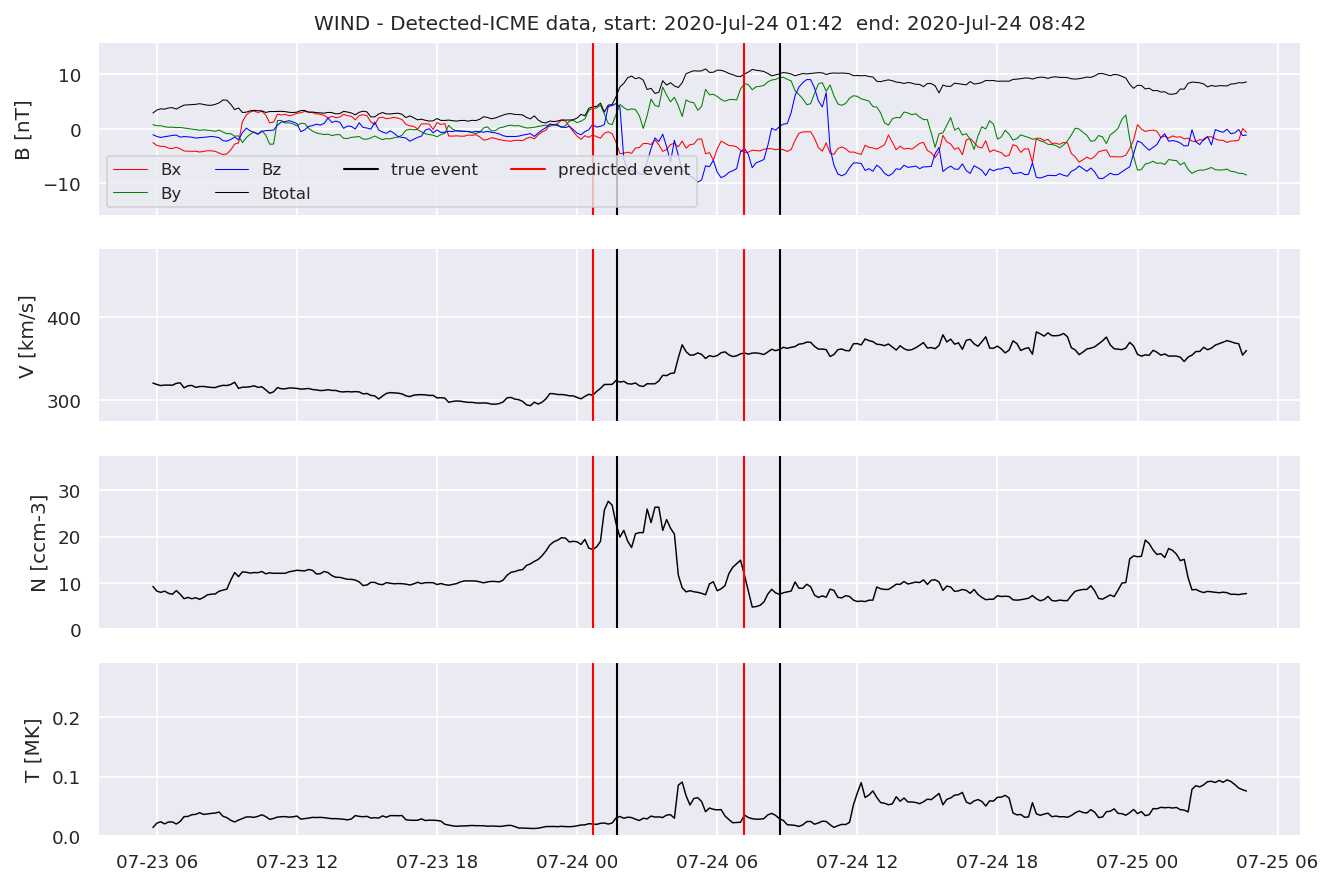

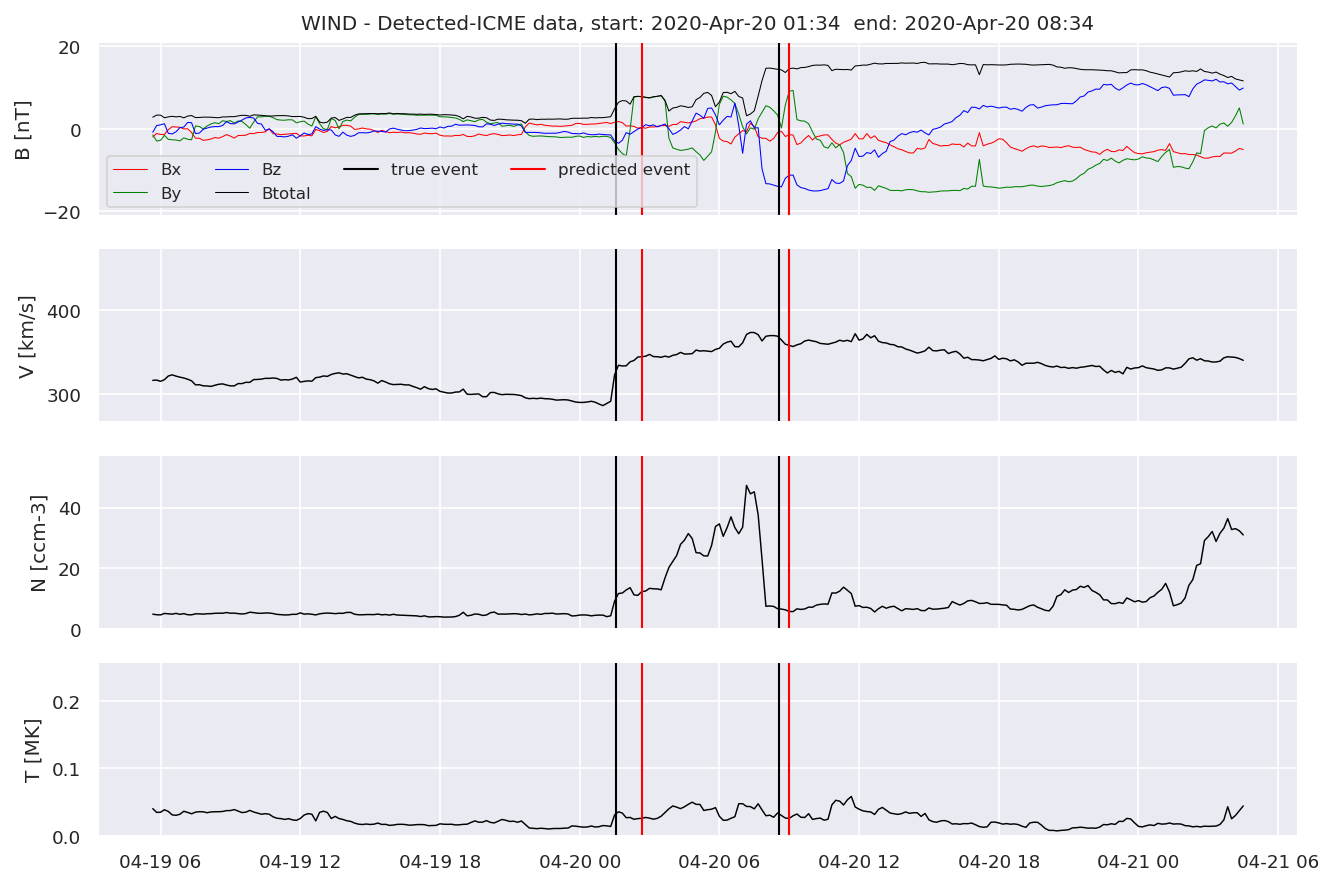

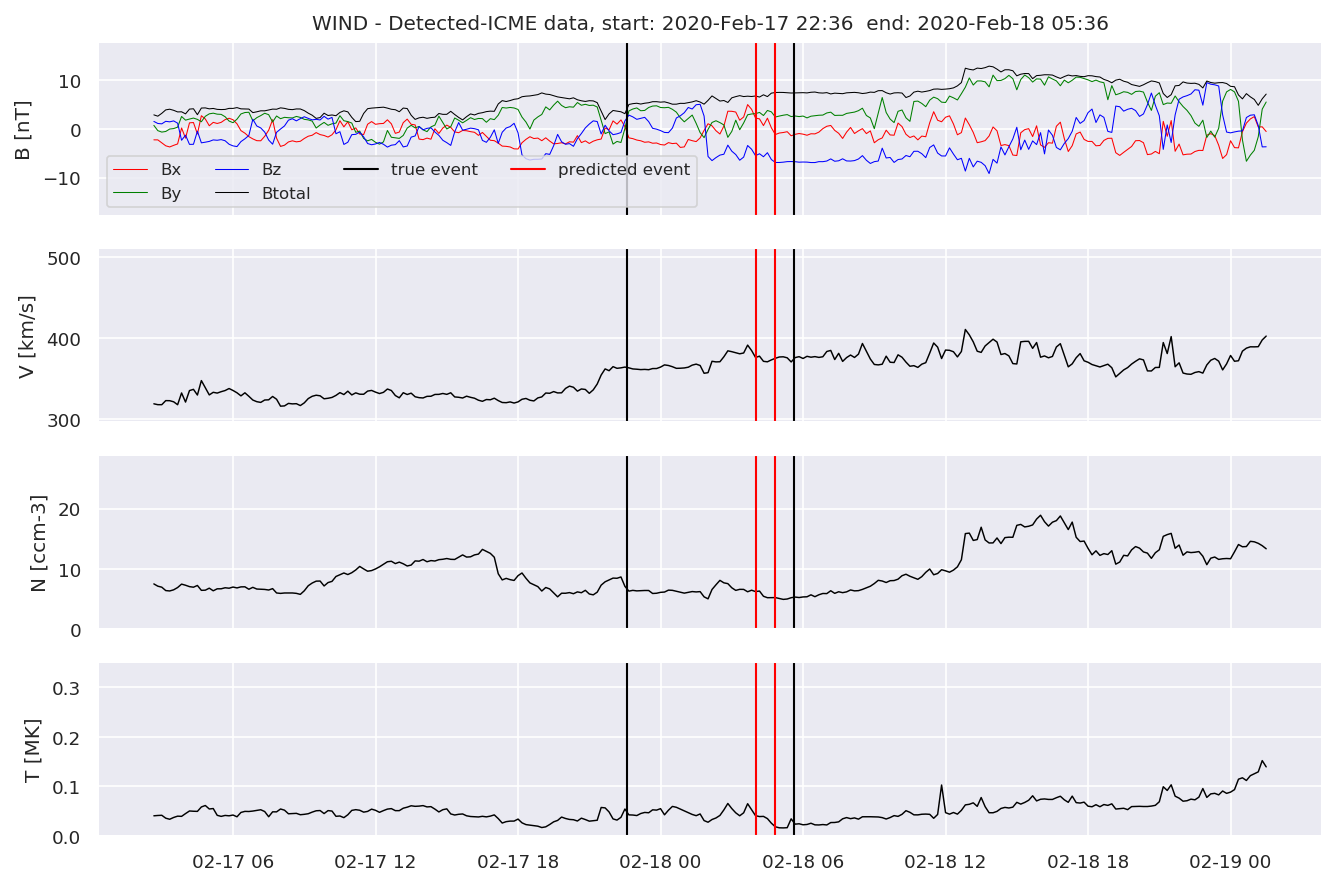

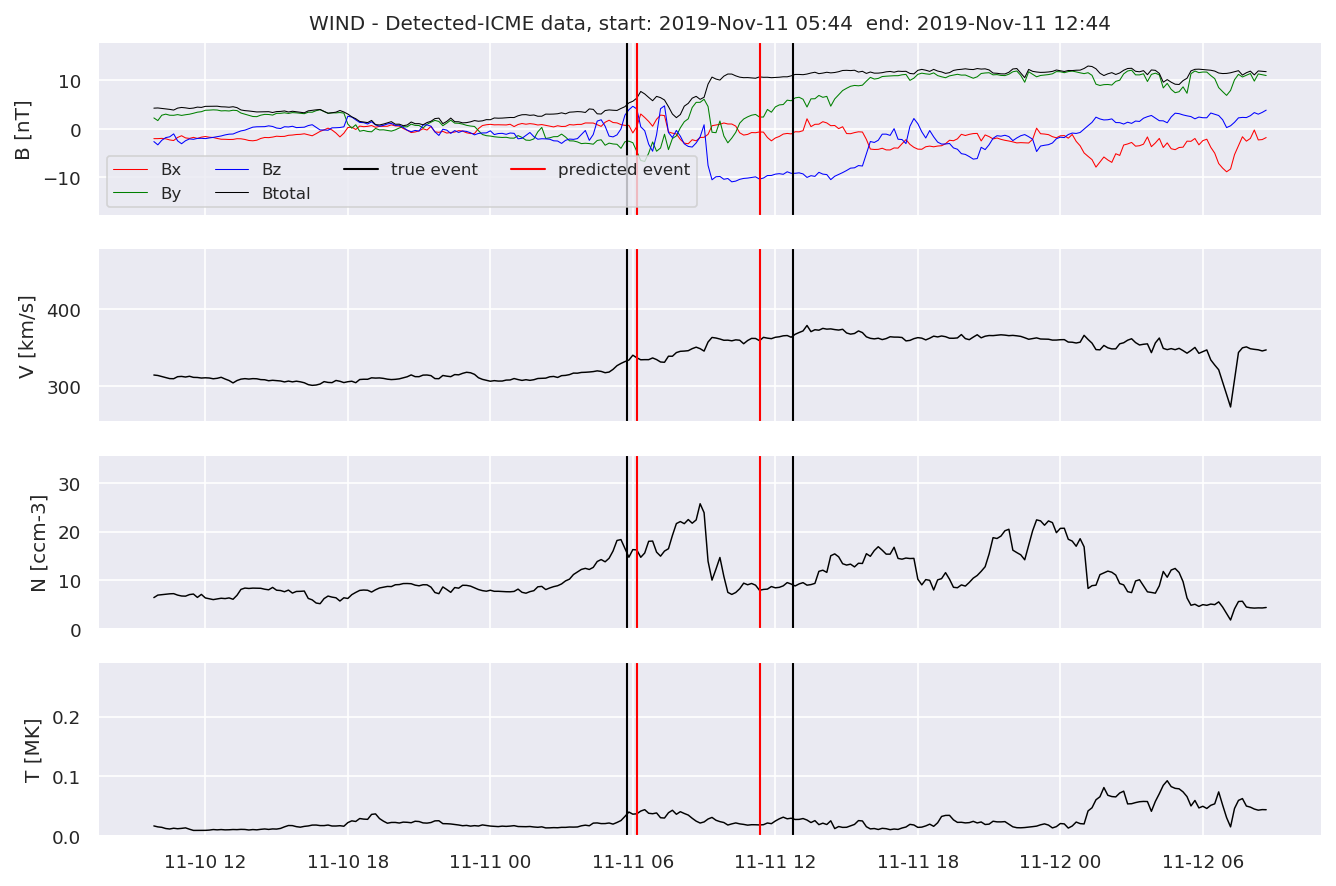

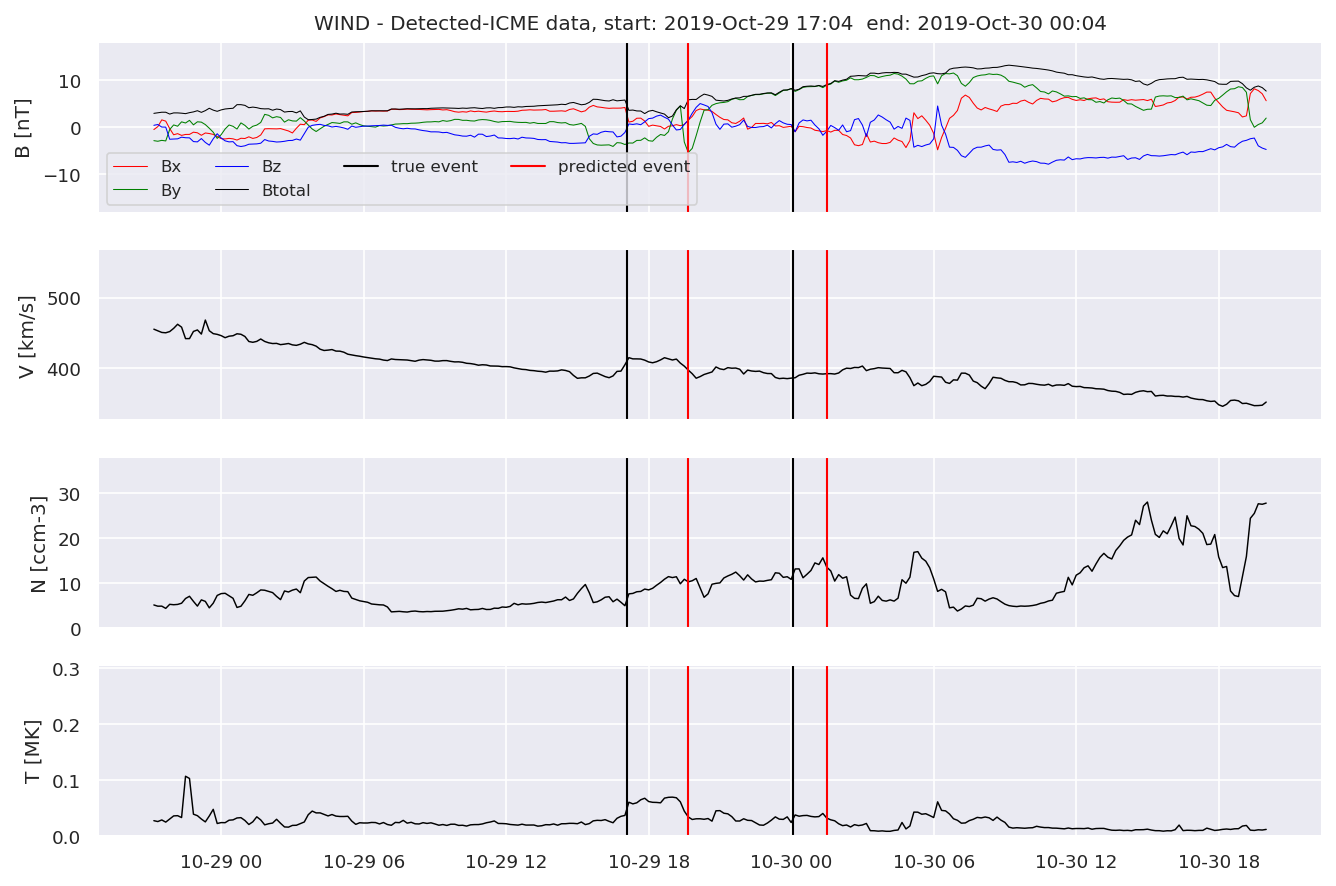

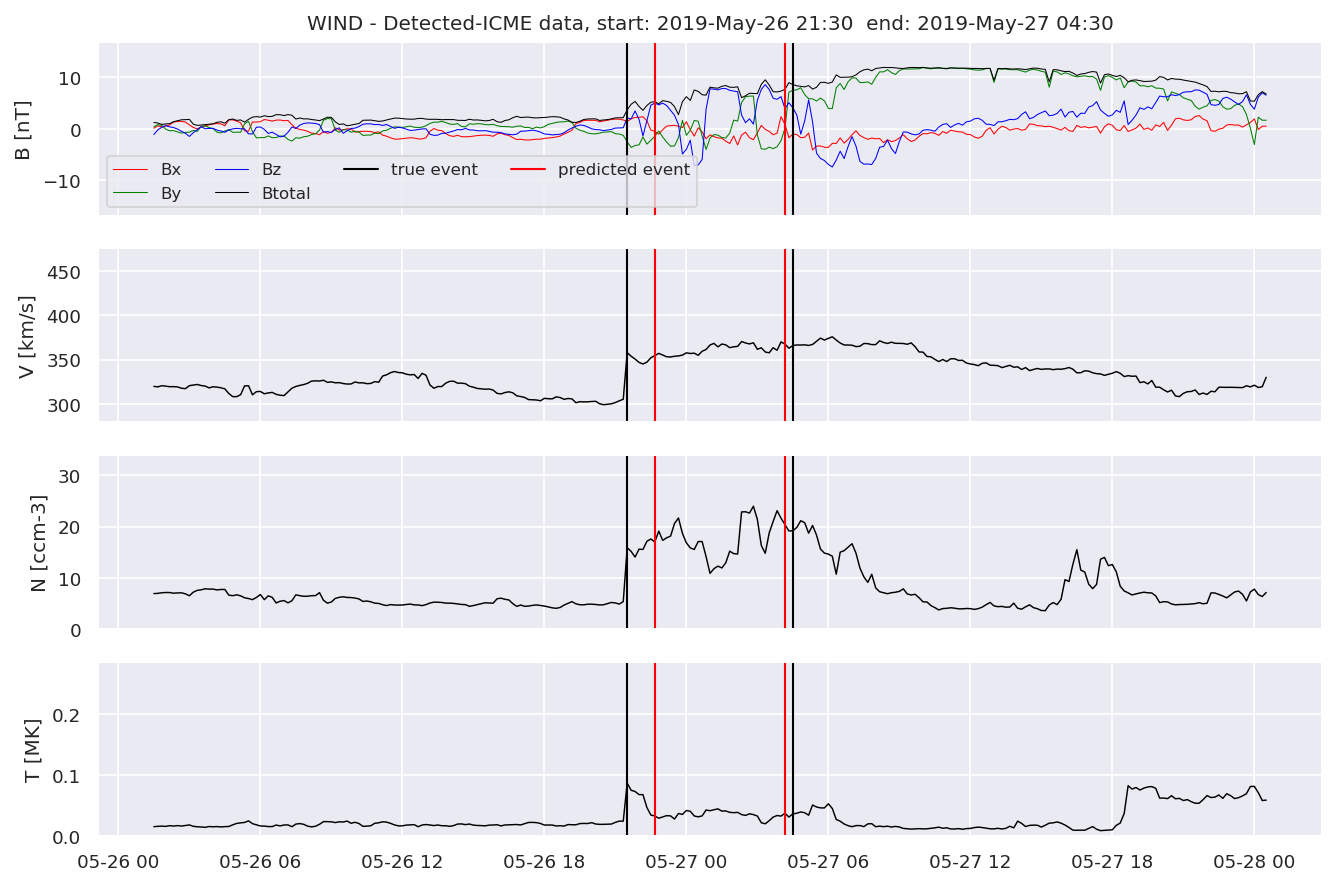

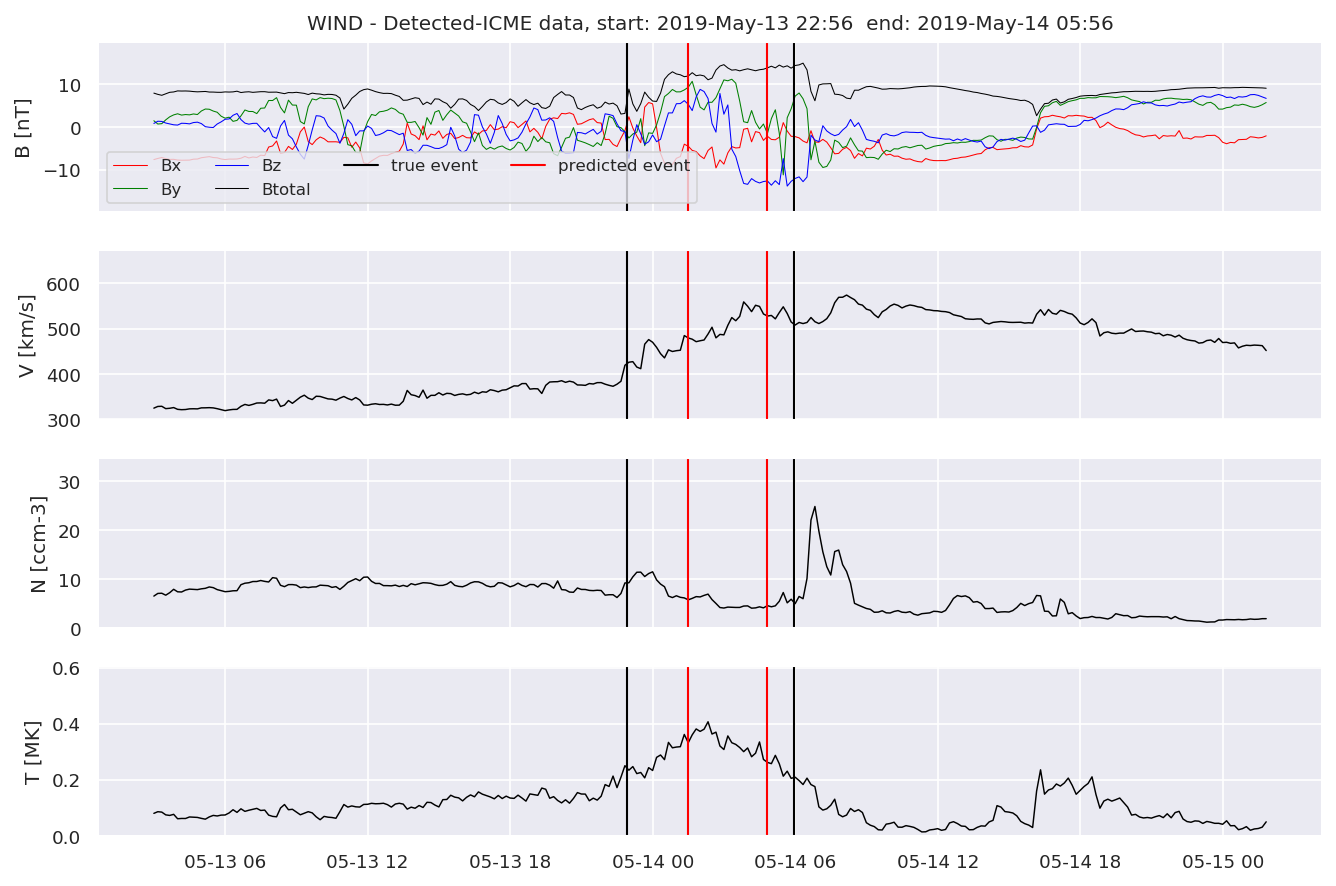

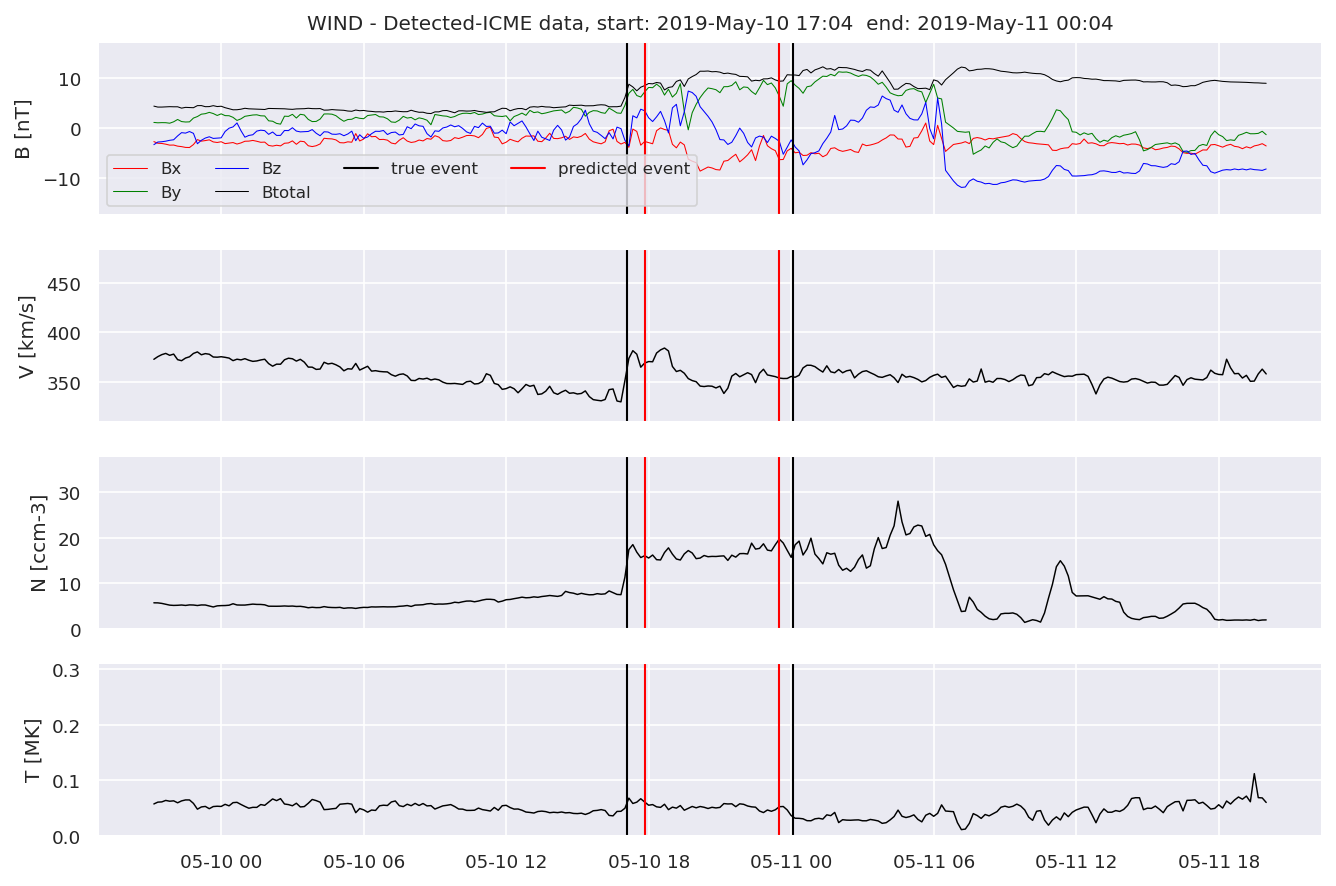

In [24]:
#Plot FNs, FPs and Detected events

for i in range(0, len(FN)):
    
    FN[i].iwfplotnopred(data, 20, i, 'WIND - FalseNegative')
    
for i in range(0, len(FP)):
    
    FP[i].iwfplotnopred(data, 20, i, 'WIND - FalsePositive')
    
    
for i in range(0, len(detected)):
    predstart = TP[i].begin
    predend = TP[i].end
    detected[i].iwfplot(data, 20, i, 'WIND - Detected-', predstart, predend)
